**<h1> Predicting the headline of a news </h1>**

## **1. Business/Real-world Problem**

### **1.1 Problem Statement**

Build a model which can Predict the headline of a news.

### **1.2 Real-world/Business objectives and constraints.**
- No strict Latency constraints.
- Interpretability is not much important.

### **1.3 Data source**
We will scrap the data from https://inshorts.com/en/read.

## **2. Include packages**

In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline
from nltk.corpus import stopwords
from gensim.scripts.glove2word2vec import glove2word2vec
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,MaxPooling1D,Conv1D,Dense,LSTM,Dropout,multiply,Embedding,Concatenate,Input,Bidirectional,TimeDistributed
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from attention import AttentionLayer
from keras import backend as K 
from datetime import datetime
from tensorflow import keras

## **3. Scraping the data**

In [0]:
"""
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm  import tqdm
# code for scraping the first page
d={'headlines':[],'news':[]}
r = requests.get("https://inshorts.com/en/read")
soup = BeautifulSoup(r.content, 'html.parser')
min_news_id = soup.findAll("script",{"type":"text/javascript"})[2].text
min_news_id = min_news_id[25:35]
soup=soup.findAll("div",{"class":"news-card z-depth-1"})
for data in soup:
    d['headlines'].append(data.find(itemprop="headline").getText())
    d['news'].append(data.find(itemprop="articleBody").getText())
# code for scraping more pages
for i in tqdm(range(2100)):
    try:
        params = {'news_offset': min_news_id}
        req = requests.post("https://inshorts.com/en/ajax/more_news",data=params)
        json_data = req.json()
        min_news_id = json_data['min_news_id']
        soup = BeautifulSoup(json_data['html'], 'html.parser')
        soup=soup.findAll("div",{"class":"news-card z-depth-1"})
        for data in soup:
            d['headlines'].append(data.find(itemprop="headline").getText())
            d['news'].append(data.find(itemprop="articleBody").getText())
    except:
        pass
# storing the data into .csv file
df = pd.DataFrame(d)
df.to_csv("inshorts_news.csv", index=False)
"""

'\nimport requests\nfrom bs4 import BeautifulSoup\nimport pandas as pd\nfrom tqdm  import tqdm\n# code for scraping the first page\nd={\'headlines\':[],\'news\':[]}\nr = requests.get("https://inshorts.com/en/read")\nsoup = BeautifulSoup(r.content, \'html.parser\')\nmin_news_id = soup.findAll("script",{"type":"text/javascript"})[2].text\nmin_news_id = min_news_id[25:35]\nsoup=soup.findAll("div",{"class":"news-card z-depth-1"})\nfor data in soup:\n    d[\'headlines\'].append(data.find(itemprop="headline").getText())\n    d[\'news\'].append(data.find(itemprop="articleBody").getText())\n# code for scraping more pages\nfor i in tqdm(range(2100)):\n    try:\n        params = {\'news_offset\': min_news_id}\n        req = requests.post("https://inshorts.com/en/ajax/more_news",data=params)\n        json_data = req.json()\n        min_news_id = json_data[\'min_news_id\']\n        soup = BeautifulSoup(json_data[\'html\'], \'html.parser\')\n        soup=soup.findAll("div",{"class":"news-card z-dep

## **4. Preprocessing the data and EDA**

**Mount the google drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Loading dataset**

In [0]:
df=pd.read_csv('/content/drive/My Drive/new1_inshorts_news.csv')

In [0]:
df

,headlines,news
0,South Africa's Zozibini Tunzi crowned Miss Uni...,Zozibini Tunzi from South Africa has been crow...
1,21-yr-old rapper Juice Wrld dies after reporte...,America's 21-year-old rapper Jarad Anthony Hig...
2,"Rajasthan Min demands ban on 'Panipat', says f...",Rajasthan Tourism Minister Vishvendra Singh on...
3,"India's Vartika crashes out of Miss Universe, ...","India's 26-year-old Vartika Singh, who entered..."
4,What was the answer that won Zozibini Tunzi th...,"In Miss Universe 2019's final round, all three..."
...,...,...
188317,Govt committee suggests cutting royalty on coal,"According to reports, an inter-ministerial com..."
188318,Police ask complainant to polish their shoes,A complainant from Muzaffarnagar in Uttar Prad...
188319,"Asus debuts ZenFone 3 series starting at ₹16,750",Asus on Monday unveiled three new smartphones ...
188320,'GDP can rise by $1tn by 100% internet access',India's GDP could be increased by an additiona...


In [0]:
df['news'][0]

"Zozibini Tunzi from South Africa has been crowned Miss Universe 2019 at the finale which was held in Atlanta, Georgia, US on Monday. Puerto Rico's Madison Anderson was named the first runner-up while Sofía Aragón from Mexico stood third at the pageant. India was represented by 26-year-old Vartika Singh, who couldn't qualify for top 10.\n"

In [0]:
df['headlines'][0]

"South Africa's Zozibini Tunzi crowned Miss Universe 2019"

In [0]:
df = df[df.notnull()]

In [0]:
df = df.dropna(how='any') 
df

,headlines,news
0,South Africa's Zozibini Tunzi crowned Miss Uni...,Zozibini Tunzi from South Africa has been crow...
1,21-yr-old rapper Juice Wrld dies after reporte...,America's 21-year-old rapper Jarad Anthony Hig...
2,"Rajasthan Min demands ban on 'Panipat', says f...",Rajasthan Tourism Minister Vishvendra Singh on...
3,"India's Vartika crashes out of Miss Universe, ...","India's 26-year-old Vartika Singh, who entered..."
4,What was the answer that won Zozibini Tunzi th...,"In Miss Universe 2019's final round, all three..."
...,...,...
188317,Govt committee suggests cutting royalty on coal,"According to reports, an inter-ministerial com..."
188318,Police ask complainant to polish their shoes,A complainant from Muzaffarnagar in Uttar Prad...
188319,"Asus debuts ZenFone 3 series starting at ₹16,750",Asus on Monday unveiled three new smartphones ...
188320,'GDP can rise by $1tn by 100% internet access',India's GDP could be increased by an additiona...


In [0]:
!pip install ftfy

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.whl size=44593 sha256=7eb700bf135915af321f56cca71e68a2e3bf500f5ae92435eff4a50cae487b53
  Stored in directory: /root/.cache/pip/wheels/8e/da/59/6c8925d571aacade638a0f515960c21c0887af1bfe31908fbf
Successfully built ftfy


**Remove any bad unicode string using ftfy package**

In [0]:
import ftfy
from tqdm import tqdm
headline = []
for i in tqdm(df.headlines):
    title = ftfy.fix_text(i)
    headline.append(title)

100%|██████████| 188322/188322 [00:07<00:00, 26052.43it/s]


In [0]:
df['headlines']=headline

In [0]:
h_len = []
for s in tqdm(df.headlines):
  w=s.split()
  h_len.append(len(w))

100%|██████████| 188322/188322 [00:00<00:00, 886061.72it/s]


In [0]:
max(h_len) # maximum length of leadline is 18

18

In [0]:
min(h_len) # minimum length of headline is 3

3

In [0]:
sum(h_len)/188322 # Avg length of headline is 9

9.480310319559052

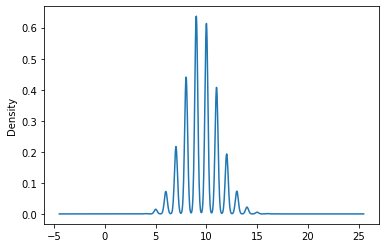

In [0]:
s = pd.Series(h_len)
ax = s.plot.kde()


Maximum headlines have length between 5-15.

Text(0, 0.5, 'headline length')

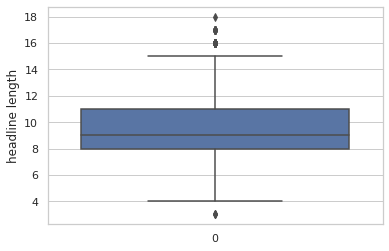

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data=h_len)
ax.set_ylabel('headline length')

observation: 75% of headlines have length below 12 words.

In [0]:
import ftfy
from tqdm import tqdm_notebook
news = []
for i in tqdm_notebook(df.news):
    title = ftfy.fix_text(i)
    news.append(title)

In [0]:
df['news']=news

In [0]:
n_len = []
for s in tqdm_notebook(df.news):
  w=s.split()
  n_len.append(len(w))

In [0]:
max(n_len) # maximum length of news is 67

67

In [0]:
min(n_len) # minimum length of news is 38

38

In [0]:
sum(n_len)/188322 # average length of news is 58

58.26926222108941

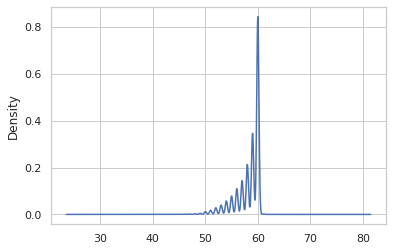

In [0]:
s = pd.Series(n_len)
ax = s.plot.kde()

observation: Nearly all news have length near 60.

Text(0, 0.5, 'news length')

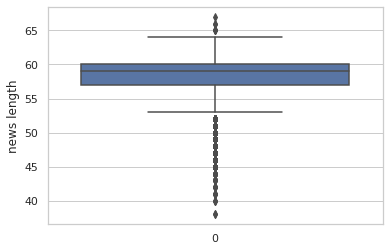

In [0]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data=n_len)
ax.set_ylabel('news length')

observation: 75% of news have length below 60 words. 

## **5. Date preprocessing**

In [0]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you'
"you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he'
'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have','had','as',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because'
'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into'
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on',
'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than'
's', 't', 'can', 'will', 'just','would']

**Headlines**

In [7]:
import re
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


from tqdm import tqdm
preprocessed1 = []
# tqdm is for printing the status bar
for sentance in tqdm(df['headlines'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed1.append(sent.lower().strip())
df['headlines']=preprocessed1


100%|██████████| 188322/188322 [00:05<00:00, 36804.26it/s]


**News**

In [8]:
import re
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase
  
from tqdm import tqdm
preprocessed2 = []
# tqdm is for printing the status bar
for sentance in tqdm(df['news'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# https://gist.github.com/sebleier/554280
  sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
  preprocessed2.append(sent.lower().strip())
df['news']=preprocessed2

100%|██████████| 188322/188322 [00:19<00:00, 9823.59it/s]


**Adding 'ssttaarrtt' and 'eenndd' token to the headlines.**

In [0]:
df['headlines'] = df['headlines'].apply(lambda x : 'ssttaarrtt '+ x + ' eenndd')

In [9]:
df['headlines'][0]

'ssttaarrtt south africa zozibini tunzi crowned miss universe 2019 eenndd'

In [10]:
df['headlines'][:1000]

0      ssttaarrtt south africa zozibini tunzi crowned...
1      ssttaarrtt 21 yr old rapper juice wrld dies af...
2      ssttaarrtt rajasthan min demands ban panipat s...
3      ssttaarrtt india vartika crashes of miss unive...
4      ssttaarrtt answer that won zozibini tunzi miss...
                             ...                        
995    ssttaarrtt aminimoon fireball recently observe...
996    ssttaarrtt do not jijas bjp karyakartas sithar...
997    ssttaarrtt police seek 10 day custody of accus...
998    ssttaarrtt half burnt body of woman found fore...
999    ssttaarrtt aapke chachere bhai lagte hain kya ...
Name: headlines, Length: 1000, dtype: object

## **7. Splitting the dataset**

In [0]:
from sklearn.model_selection import train_test_split
X_1, X_test, y_1, y_test = train_test_split(np.array(df['news']),np.array(df['headlines']), test_size=0.005)
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.15)

In [0]:
print(X_tr.shape)
print(X_cv.shape)
print(X_test.shape)

(159273,)
(28107,)
(942,)


In [0]:
X_tr

array(['mobile chipmaker qualcomm tuesday unveiled snapdragon x20 lte modem offers download speed of 1 2 gbps 20 improvement over previous generation achieve speed qualcomm modem downloads 12 unique data streams of 100 mbps each upload speed of x20 lte modem 150 mbps',
       'twitter co founder ceo jack dorsey friday apologised allowing advertisement promoting white supremacist group platform made mistake apologise automated system allowed ad promoting hate policy retro fixed dorsey tweeted twitter recently suspended number of accounts over hate speech',
       'actor dwayne johnson has said he not rule working bollywood added that he has lot of respect bollywood referring actor varun dhawan dwayne stated he big fan interacted him social media know he big star india maybe one day you could see bollywood action movie',
       ...,
       'telangana minister kt rama rao has urged officials public representatives students of all state run institutions wear handloom clothes at least week 

**Tokenizing and padding the sequences**

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

**Tokenize news**

In [0]:
t = Tokenizer()
t.fit_on_texts(X_tr)
vocab_size = len(t.word_index) + 1 # for index zero we have to add +1  
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_tr)
encoded_docs_test = t.texts_to_sequences(X_test)
encoded_docs_cv = t.texts_to_sequences(X_cv)
max_length = 70
padded_docs_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_length, padding='post')


In [14]:
padded_docs_train[0]

array([  248,   805,   108,    21,  5706,    46,    20, 25069, 16780,
        1081,    10,     3,  1251,  1222,  2011,    29,    81,    71,
       10524,   902,  3255,   611, 16781,  7073,     5,    11,    21,
         374,    29,  4325,    37,     3,     5,   227,  1690,   454,
         219,    26,  2305,    35, 30767,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [15]:
t.word_index

{'of': 1,
 'has': 2,
 'said': 3,
 'that': 4,
 'he': 5,
 'his': 6,
 'after': 7,
 'at': 8,
 'not': 9,
 'india': 10,
 'added': 11,
 'year': 12,
 'over': 13,
 'also': 14,
 'us': 15,
 'she': 16,
 'their': 17,
 'first': 18,
 'government': 19,
 'people': 20,
 'while': 21,
 'two': 22,
 'police': 23,
 'indian': 24,
 'minister': 25,
 'they': 26,
 'old': 27,
 'crore': 28,
 'film': 29,
 '1': 30,
 'world': 31,
 'president': 32,
 'one': 33,
 'new': 34,
 'him': 35,
 'reportedly': 36,
 'further': 37,
 'all': 38,
 'state': 39,
 '000': 40,
 'during': 41,
 'court': 42,
 'years': 43,
 'delhi': 44,
 'former': 45,
 'time': 46,
 'bjp': 47,
 '2': 48,
 'congress': 49,
 'last': 50,
 'three': 51,
 'pakistan': 52,
 'based': 53,
 'you': 54,
 'reports': 55,
 'modi': 56,
 '5': 57,
 'like': 58,
 'pm': 59,
 'company': 60,
 'earlier': 61,
 'party': 62,
 'into': 63,
 'chief': 64,
 'singh': 65,
 'day': 66,
 'them': 67,
 'country': 68,
 'team': 69,
 'million': 70,
 'no': 71,
 'monday': 72,
 'tuesday': 73,
 'wednesday': 74

**Tokenize headlines**

In [0]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(y_tr)
y_vocab_size = len(y_tokenizer.word_index) + 1
# integer encode the documents
y_encoded_docs = y_tokenizer.texts_to_sequences(y_tr)

y_encoded_docs_test = y_tokenizer.texts_to_sequences(y_test)
y_encoded_docs_cv = y_tokenizer.texts_to_sequences(y_cv)
y_max_length = 20
y_padded_docs_train = pad_sequences(y_encoded_docs, maxlen=y_max_length, padding='post')
y_padded_docs_test = pad_sequences(y_encoded_docs_test, maxlen=y_max_length, padding='post')
y_padded_docs_cv = pad_sequences(y_encoded_docs_cv, maxlen=y_max_length, padding='post')


In [17]:
y_tokenizer.word_index

{'ssttaarrtt': 1,
 'eenndd': 2,
 'of': 3,
 'india': 4,
 'not': 5,
 'after': 6,
 'at': 7,
 'over': 8,
 'us': 9,
 'pm': 10,
 '2': 11,
 'man': 12,
 'govt': 13,
 '1': 14,
 'world': 15,
 'bjp': 16,
 'delhi': 17,
 'old': 18,
 '3': 19,
 'new': 20,
 'indian': 21,
 'modi': 22,
 'trump': 23,
 'crore': 24,
 'report': 25,
 '5': 26,
 '1st': 27,
 'his': 28,
 'year': 29,
 'cm': 30,
 'no': 31,
 'first': 32,
 'pak': 33,
 'woman': 34,
 '000': 35,
 '4': 36,
 'ex': 37,
 'video': 38,
 'day': 39,
 'time': 40,
 '10': 41,
 'people': 42,
 'k': 43,
 'reports': 44,
 'has': 45,
 'china': 46,
 'do': 47,
 'cr': 48,
 'police': 49,
 'killed': 50,
 'years': 51,
 '6': 52,
 'women': 53,
 'yr': 54,
 'case': 55,
 'lakh': 56,
 'gets': 57,
 'mumbai': 58,
 'sc': 59,
 'film': 60,
 'get': 61,
 'ceo': 62,
 'startup': 63,
 'says': 64,
 'rahul': 65,
 's': 66,
 '7': 67,
 'may': 68,
 'chief': 69,
 'test': 70,
 'win': 71,
 'uk': 72,
 'j': 73,
 'that': 74,
 'pakistan': 75,
 'minister': 76,
 'google': 77,
 'arrested': 78,
 'all': 79,


In [18]:
y_padded_docs_train[0]

array([    1,  2246,   883, 12565,  1088,     4,  1366,    60,    83,
         284,     2,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

**Loading the word vectors**

Download glove word vectors

In [14]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/213609/464671/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1584850356&Signature=jQ0PXa83Tceu%2B%2FTH8%2FcUJgeRUW5kAje0OqkUK92vPwT9Ut9c%2BWQ5aE2XD44Vi%2FUejiBGZNUHBSLouHbFEh9VicPvPgHXiR%2FcECkjrqkkDiIuxHrW%2BGahIVZfyQYyQm6G508DVYQbHUjr5UBBiz1ziBcPYQIJ%2FadPB9oSlmiH80VE3eNMtD7aEWAiIBF4g34IU48QUZEIKqWDCXXriNIPALl%2FwcCxZR5BubOM4O9gCmG6xgxdFD3T99NZb%2Birm1WqnyZ2qanALgbDCGRyqMCJ5ogqzmKvY3ap%2BdzFB8ueZ6bJ5L7s%2FAbVRu0KuBLodOtNQJ5t78Mtgoh9lcjyA0kFNg%3D%3D&response-content-disposition=attachment%3B+filename%3Dglove42b300dtxt.zip" -O "glove42b300dtxt.zip" -c

--2020-03-21 14:29:07--  https://storage.googleapis.com/kaggle-data-sets/213609/464671/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1584850356&Signature=jQ0PXa83Tceu%2B%2FTH8%2FcUJgeRUW5kAje0OqkUK92vPwT9Ut9c%2BWQ5aE2XD44Vi%2FUejiBGZNUHBSLouHbFEh9VicPvPgHXiR%2FcECkjrqkkDiIuxHrW%2BGahIVZfyQYyQm6G508DVYQbHUjr5UBBiz1ziBcPYQIJ%2FadPB9oSlmiH80VE3eNMtD7aEWAiIBF4g34IU48QUZEIKqWDCXXriNIPALl%2FwcCxZR5BubOM4O9gCmG6xgxdFD3T99NZb%2Birm1WqnyZ2qanALgbDCGRyqMCJ5ogqzmKvY3ap%2BdzFB8ueZ6bJ5L7s%2FAbVRu0KuBLodOtNQJ5t78Mtgoh9lcjyA0kFNg%3D%3D&response-content-disposition=attachment%3B+filename%3Dglove42b300dtxt.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928408067 (1.8G) [application/zip]
Saving to: ‘glove42b300dtxt.zip’

glove42b300dtxt.zip 100%[============

In [15]:
!unzip glove42b300dtxt.zip

Archive:  glove42b300dtxt.zip
  inflating: glove.42B.300d.txt      


**Creating dictionary which contain word as key and 300 vectors as value.**

In [16]:
from numpy import asarray
from tqdm import tqdm_notebook
embeddings_index = dict()
f = open('glove.42B.300d.txt')
for line in tqdm_notebook(f):
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

**News word vector matrix (encoder input matrix)**

In [17]:
from numpy import zeros
input_matrix = zeros((vocab_size, 300))
for word, i in tqdm_notebook(t.word_index.items()):
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    input_matrix[i] = embedding_vector

**Headlines word vector matrix (decoder input matrix)**

In [18]:
from numpy import zeros
decoder_matrix = zeros((y_vocab_size, 300))
for word, i in tqdm_notebook(y_tokenizer.word_index.items()):
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    decoder_matrix[i] = embedding_vector

News data contains total 104870 different words.

In [24]:
input_matrix.shape

(104945, 300)

In [85]:
decoder_matrix.shape

(44499, 300)

# **Modelling**

## **Model 1**

## **LSTM Encoder + Bahdanau Attention + LSTM decoder**


In [86]:
# to plot the tensorboard

emb_dim = 300

encoder_input = Input(shape=(70,))
x1=Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)(encoder_input)
e_lstm_out, e_hidden_out, e_cell_out = LSTM(32,return_sequences=True,return_state=True)(x1)

decoder_input = Input(shape=(None,))

decoder_embedding_layer = Embedding(y_vocab_size, 300,weights=[decoder_matrix],trainable=False)
decoder_embedding = decoder_embedding_layer(decoder_input)

decoder_lstm = LSTM(32, return_sequences=True, return_state=True)
d_lstm_out,d_hidden_out,d_cell_out = decoder_lstm(decoder_embedding,initial_state=[e_hidden_out, e_cell_out])
#https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
attention_layer = AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer([e_lstm_out, d_lstm_out])

# Concat attention input and decoder LSTM output
concat = Concatenate(axis=-1, name='concat_layer')([d_lstm_out, attention_out])

decoder_dense =  Dense(y_vocab_size, activation='softmax')
decoder_dense_outputs = decoder_dense(concat)

# Define the model 
model = Model([encoder_input, decoder_input], decoder_dense_outputs)

model.summary()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 70, 300)      31483500    input_16[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 300)    13349700    input_17[0][0]                   
____________________________________________________________________________________________

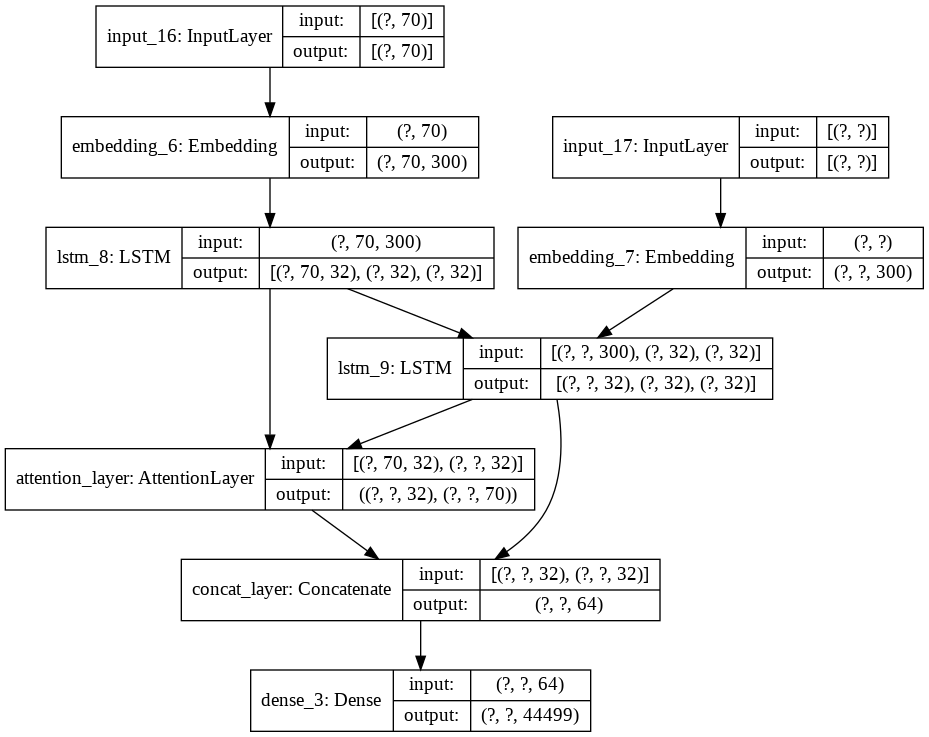

In [87]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

### **ephocs=8 and batch_size=128**

In [88]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
t1=padded_docs_train
t2=y_padded_docs_train
t1_cv=padded_docs_cv
t2_cv=y_padded_docs_cv
history=model.fit([t1,t2[:,:-1]],
                  t2.reshape(t2.shape[0],t2.shape[1], 1)[:,1:]
                  ,epochs=8,batch_size=128, validation_data=([t1_cv,t2_cv[:,:-1]],
                  t2_cv.reshape(t2_cv.shape[0],t2_cv.shape[1], 1)[:,1:]),
                  callbacks=[tensorboard_callback])

Train on 159273 samples, validate on 28107 samples
Epoch 1/8
159273/159273 [==============================] - 261s 2ms/sample - loss: 4.0625 - val_loss: 3.4938
Epoch 2/8
159273/159273 [==============================] - 254s 2ms/sample - loss: 3.3461 - val_loss: 3.1206
Epoch 3/8
159273/159273 [==============================] - 253s 2ms/sample - loss: 3.0556 - val_loss: 2.9285
Epoch 4/8
159273/159273 [==============================] - 253s 2ms/sample - loss: 2.8753 - val_loss: 2.8056
Epoch 5/8
159273/159273 [==============================] - 253s 2ms/sample - loss: 2.7475 - val_loss: 2.7235
Epoch 6/8
159273/159273 [==============================] - 256s 2ms/sample - loss: 2.6519 - val_loss: 2.6653
Epoch 7/8
159273/159273 [==============================] - 258s 2ms/sample - loss: 2.5773 - val_loss: 2.6208
Epoch 8/8
159273/159273 [==============================] - 255s 2ms/sample - loss: 2.5173 - val_loss: 2.5878


**Inference**

In [0]:
news_word_index=t.index_word
headlines_word_index=y_tokenizer.index_word
target_headlines_word_index=y_tokenizer.word_index

In [0]:
encoder_model = Model(inputs=encoder_input,outputs=[e_lstm_out, e_hidden_out, e_cell_out])

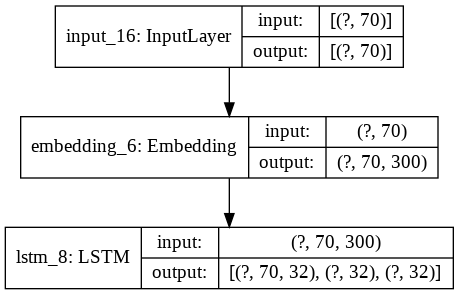

In [90]:
plot_model(encoder_model, to_file='model.png', show_shapes=True)

In [0]:
decoder_input_h = Input(shape=(32,))
decoder_input_c = Input(shape=(32,))
decoder_hidden_state = Input(shape=(70,32))

dec_emb2= decoder_embedding_layer(decoder_input) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_input_h, decoder_input_c])

attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_input] + [decoder_hidden_state,decoder_input_h, decoder_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


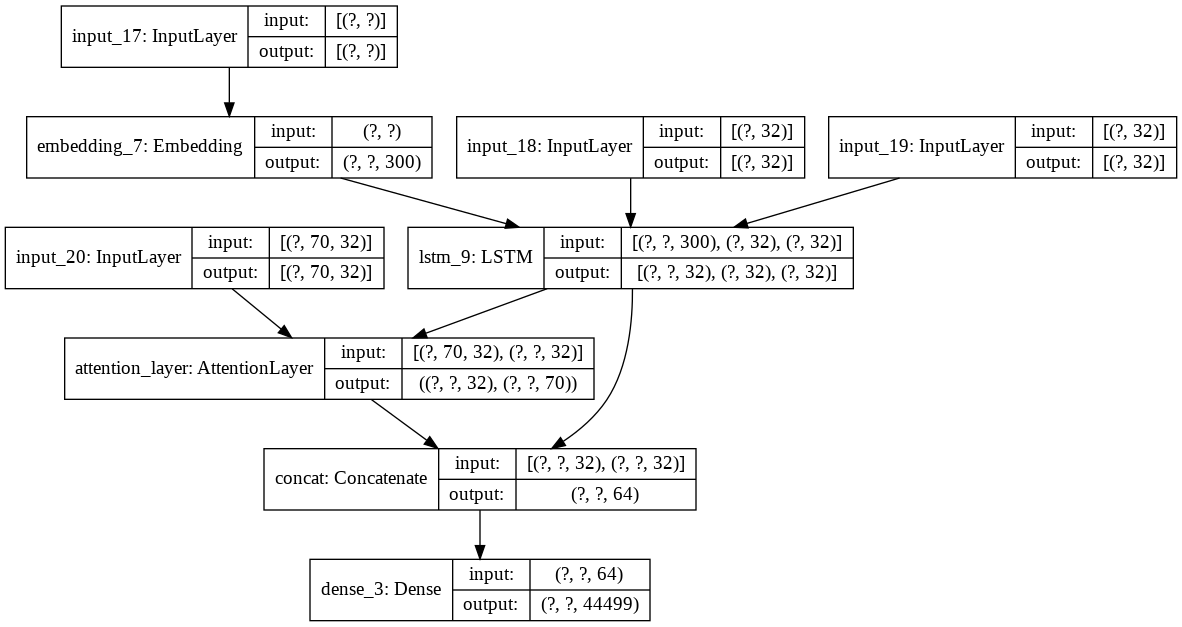

In [92]:
plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [0]:
# https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
# https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    seq[0, 0] = target_headlines_word_index['ssttaarrtt']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output, h, c = decoder_model.predict([seq] + [e_out, e_h, e_c])
        
        token_index = np.argmax(output[0, -1, :])
        if(token_index==0):
          token_index=2
        try:
          token = headlines_word_index[token_index]
                          
          if(token!='eenndd'):
            decoded_sentence += ' '+token

        # Exit condition: either hit max length or find stop word.
          if (token == 'eenndd'  or len(decoded_sentence.split()) >= (20-1)):
            stop_condition = True
        except:
          pass
        # Update the target sequence (of length 1).
        seq = np.zeros((1,1))
        seq[0, 0] = token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def headlines(input_seq):
    s=''
    for i in input_seq:
        if((i!=0 and i!=target_headlines_word_index['ssttaarrtt']) and i!=target_headlines_word_index['eenndd']):
            s=s+headlines_word_index[i]+' '
    return s

def news(input_seq):
    s=''
    
    for i in input_seq:
        if(i!=0):
            s=s+news_word_index[i]+' '
    return s


In [95]:
for i in range(5):
  print("News:",news(padded_docs_train[i]))
  print("Original headline:",headlines(y_padded_docs_train[i]))
  print("Predicted headline:",decode_sequence(padded_docs_train[i].reshape(1,70)))
  print("\n")

News: shah rukh khan while recalling time people apprehensive chak de india said everyone thought worst film made no heroine girls unknown look awful beard he added while talking film srk further said he does certain films because they appeal him organically 
Original headline: everyone said chak de india worst film made srk 
Predicted headline:  not want not want not want srk


News: transportation security administration has announced more comprehensive involved physical screening of passengers at us airports new pat rule comes after audit homeland security revealed that airport officers failed detect guns weapons passengers us airports subjected pat searches they refuse pass through imaging scanners 
Original headline: pat downs at us airports get more invasive 
Predicted headline:  us airlines cancels over 1 000 flights


News: 20 year old indonesian man allegedly forged his diploma overstated his grades gain admission into police academy has arrested discrepancy noticed police edu

In [96]:
for i in range(5):
  print("News:",news(padded_docs_test[i]))
  print("Original headline:",headlines(y_padded_docs_test[i]))
  print("Predicted headline:",decode_sequence(padded_docs_test[i].reshape(1,70)))
  print("\n")

News: former american swimmer michael phelps decorated olympian of all time has said he extremely thankful that he not end his life while fighting depression 23 time olympic gold medalist added that he suffered depression after every olympic games his career phelps further said he not want live anymore after 2012 olympics 
Original headline: under depression after every olympics 23 time champion 
Predicted headline:  phelps phelps he he he he aged year


News: proxy advisory firms come support of infosys co founder narayana murthy stance making panaya probe report public infosys earlier declined murthy request claimed that management has cleared of alleged wrongdoings advisory firms also questioned company stock performance asked founders specific plan put infosys back stability track 
Original headline: advisory firms back murthy over making panaya probe public 
Predicted headline:  infosys ceo resigns over 1 months after infosys


News: konkona sen sharma has named best actress film 

### Model 1 BLEU score

In [97]:
h=[]
s=[]
for i in range(942):
  h1=[headlines(y_padded_docs_test[i]).split()]
  h.append(h1)
  s.append(decode_sequence(padded_docs_test[i].reshape(1,70)).split())

from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(h, s, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(h, s, weights=(0.5, 0.5, 0, 0)))


BLEU-1: 0.132946
BLEU-2: 0.053922


## **Model 2**

## **Model with stop words not removed from headlines.**

In [0]:
from keras import backend as K 
logdir = "log2/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

emb_dim = 300

encoder_input = Input(shape=(70,))
x1=Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)(encoder_input)
e_lstm_out, e_hidden_out, e_cell_out = LSTM(750,return_sequences=True,return_state=True)(x1)

decoder_input = Input(shape=(None,))

decoder_embedding_layer = Embedding(y_vocab_size, 300,weights=[decoder_matrix],trainable=False)
decoder_embedding = decoder_embedding_layer(decoder_input)

decoder_lstm = LSTM(750, return_sequences=True, return_state=True)
d_lstm_out,d_hidden_out,d_cell_out = decoder_lstm(decoder_embedding,initial_state=[e_hidden_out, e_cell_out])
# https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
attention_layer = AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer([e_lstm_out, d_lstm_out])

# Concat attention input and decoder LSTM output
concat = Concatenate(axis=-1, name='concat_layer')([d_lstm_out, attention_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_dense_outputs = decoder_dense(concat)

# Define the model 
model = Model([encoder_input, decoder_input], decoder_dense_outputs)

model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 70, 300)      31475400    input_1[0][0]                    
_____________________________________________________________________________________________

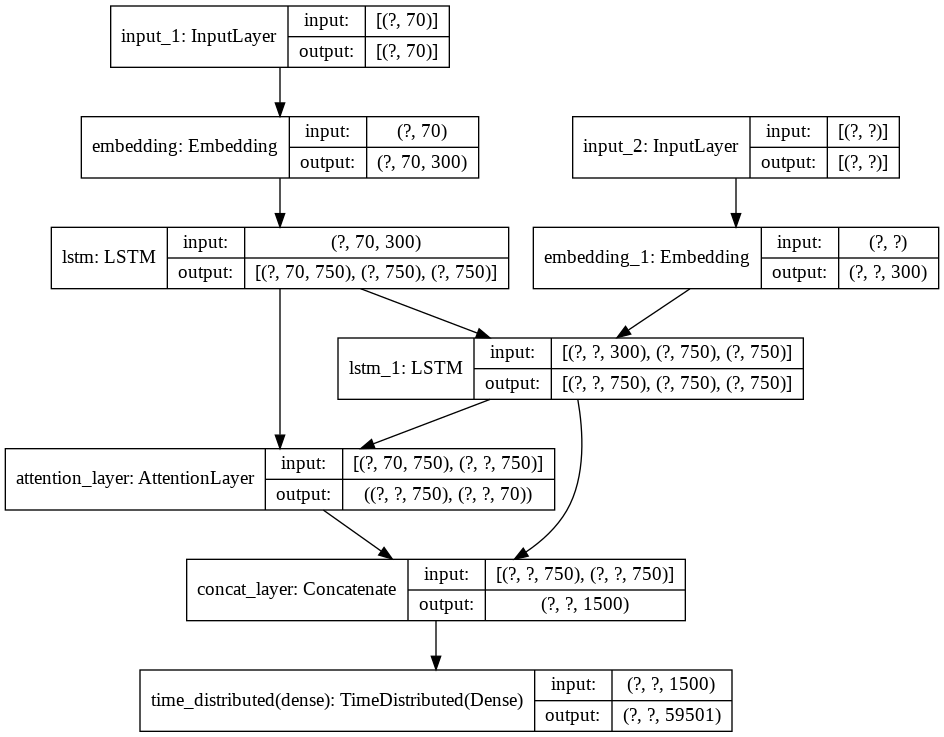

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

## **epochs=4 , batch size=32**

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
t1=padded_docs_train
t2=y_padded_docs_train
t1_cv=padded_docs_cv
t2_cv=y_padded_docs_cv
history=model.fit([t1,t2[:,:-1]],
                  t2.reshape(t2.shape[0],t2.shape[1], 1)[:,1:]
                  ,epochs=4,batch_size=32, validation_data=([t1_cv,t2_cv[:,:-1]],
                  t2_cv.reshape(t2_cv.shape[0],t2_cv.shape[1], 1)[:,1:]),
                  callbacks=[tensorboard_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 159273 samples, validate on 28107 samples
Epoch 1/4
159273/159273 [==============================] - 1107s 7ms/sample - loss: 3.1743 - val_loss: 2.3073
Epoch 2/4
159273/159273 [==============================] - 1104s 7ms/sample - loss: 1.9250 - val_loss: 1.9487
Epoch 3/4
159273/159273 [==============================] - 1103s 7ms/sample - loss: 1.3774 - val_loss: 1.9219
Epoch 4/4
159273/159273 [==============================] - 1103s 7ms/sample - loss: 1.0481 - val_loss: 1.9611


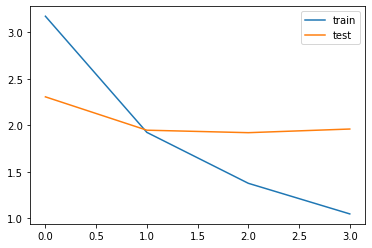

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
encoder_model = Model(inputs=encoder_input,outputs=[e_lstm_out, e_hidden_out, e_cell_out])

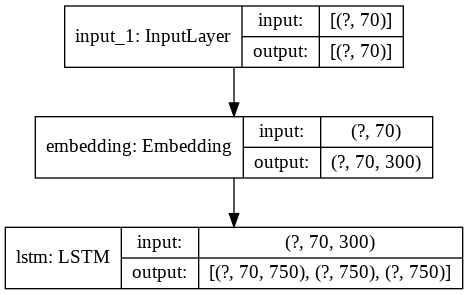

In [0]:
plot_model(encoder_model, to_file='model.png', show_shapes=True)

In [0]:
decoder_input_h = Input(shape=(750,))
decoder_input_c = Input(shape=(750,))
decoder_hidden_state = Input(shape=(70,750))

dec_emb2= decoder_embedding_layer(decoder_input) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_input_h, decoder_input_c])

attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_input] + [decoder_hidden_state,decoder_input_h, decoder_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

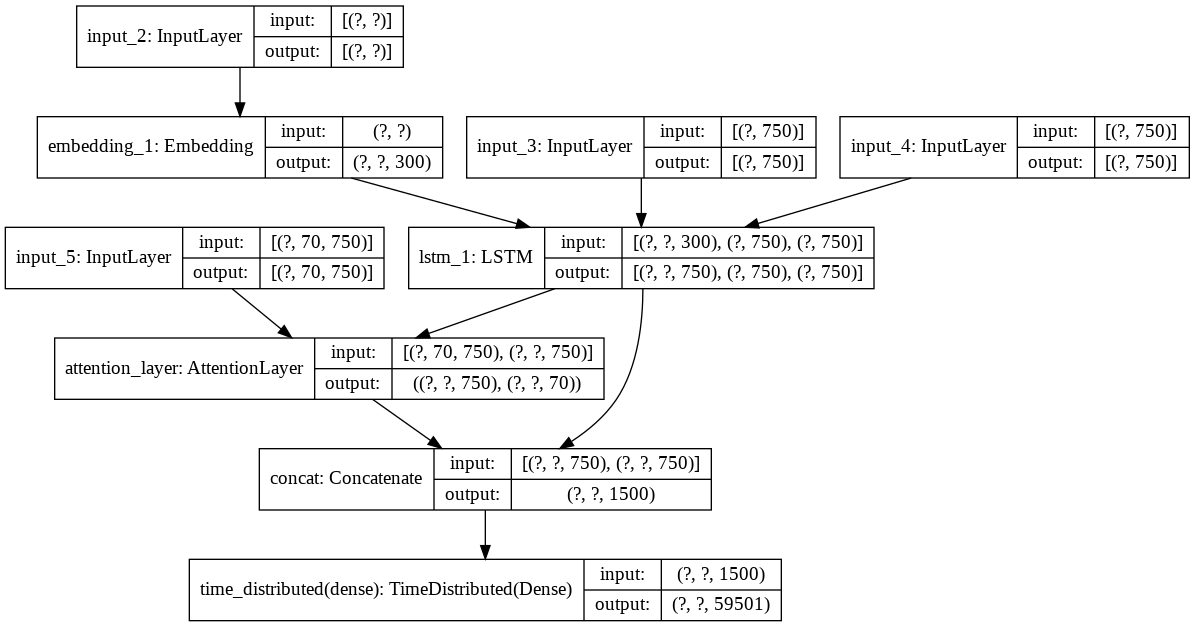

In [0]:
plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [0]:
# https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
# https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    seq[0, 0] = target_headlines_word_index['ssttaarrtt']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
      
        output, h, c = decoder_model.predict([seq] + [e_out, e_h, e_c])
        
        token_index = np.argmax(output[0, -1, :])
        if(token_index==0):
          token_index=2
        try:
          token = headlines_word_index[token_index]
                          
          if(token!='eenndd'):
            decoded_sentence += ' '+token

        # Exit condition: either hit max length or find stop word.
          if (token == 'eenndd'  or len(decoded_sentence.split()) >= (20-1)):
            stop_condition = True
        except:
          pass
        # Update the target sequence (of length 1).
        seq = np.zeros((1,1))
        seq[0, 0] = token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def headlines(input_seq):
    s=''
    for i in input_seq:
        if((i!=0 and i!=target_headlines_word_index['ssttaarrtt']) and i!=target_headlines_word_index['eenndd']):
            s=s+headlines_word_index[i]+' '
    return s

def news(input_seq):
    s=''
    
    for i in input_seq:
        if(i!=0):
            s=s+news_word_index[i]+' '
    return s


In [0]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_train[i]))
  print("Original headline:",headlines(y_padded_docs_train[i]))
  print("Predicted headline:",decode_sequence(padded_docs_train[i].reshape(1,70)))
  print("\n")

1
News: uber pilot new opt safety feature let users record audio through app during ongoing ride select cities brazil mexico starting december users able submit clip they wish report safety incident after ride riders drivers not able listen recorded audio 
Original headline: uber to test feature to record audio during rides in brazil mexico 
Predicted headline:  uber to get safety feature after rides rides app tracks in brazil


2
News: separatist organisations jammu kashmir extended their strike till december 1 across kashmir valley however strike relaxed saturday monday they said additionally strike relaxed partially november 30 december 1 has unrest across valley following encounter of hizbul mujahideen commander burhan wani july 
Original headline: separatists extend strike till dec 1 in kashmir 
Predicted headline:  separatists in j k extended to their strike till december 1


3
News: talking his film super 30 hrithik roshan has revealed that his mother pinkie roshan watched film 

In [0]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_test[i]))
  print("Original headline:",headlines(y_padded_docs_test[i]))
  print("Predicted headline:",decode_sequence(padded_docs_test[i].reshape(1,70)))
  print("\n")

1
News: oyo bringing comfort design concept us 150 hotels across 60 cities 21 states promising deliver value chic hospitality at affordable prices aims empower independent hoteliers make reality guests oyo brings world class design capabilities pricing revenue management innovative technology talent real estate owners around world 
Original headline: oyo commits to redefine the hospitality landscape in the us 
Predicted headline:  oyo brings us cities with 60 cities in 60 cities


2
News: cheteshwar pujara has become third indian ninth overall batsman history bat all five days of test achieving feat first test sri lanka at eden gardens before pujara former indian cricketers ml jaisimha ravi shastri achieved feat both of at eden gardens 
Original headline: pujara third indian to bat on all 5 days of a test 
Predicted headline:  pujara 3rd indian to hit centuries in all 5 days in all 5 days


3
News: parliamentary panel examine various security issues related payments banking sector has 

## Model 2 BLEU score

In [0]:
h=[]
s=[]
for i in range(942):
  h1=[headlines(y_padded_docs_test[i]).split()]
  h.append(h1)
  s.append(decode_sequence(padded_docs_test[i].reshape(1,70)).split())

from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(h, s, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(h, s, weights=(0.5, 0.5, 0, 0)))


BLEU-1: 0.365156
BLEU-2: 0.232804


# **Stop words removed from both headlines and news for all below models**

## **Model 3**

## **LSTM Encoder(750 units) + Bahdanau Attention + LSTM decoder(750 units)**

In [54]:
from keras import backend as K 
logdir = "log3/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

emb_dim = 300

encoder_input = Input(shape=(70,))
x1=Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)(encoder_input)
e_lstm_out, e_hidden_out, e_cell_out = LSTM(750,return_sequences=True,return_state=True)(x1)

decoder_input = Input(shape=(None,))

decoder_embedding_layer = Embedding(y_vocab_size, 300,weights=[decoder_matrix],trainable=False)
decoder_embedding = decoder_embedding_layer(decoder_input)

decoder_lstm = LSTM(750, return_sequences=True, return_state=True)
d_lstm_out,d_hidden_out,d_cell_out = decoder_lstm(decoder_embedding,initial_state=[e_hidden_out, e_cell_out])
# https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
attention_layer = AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer([e_lstm_out, d_lstm_out])

# Concat attention input and decoder LSTM output
concat = Concatenate(axis=-1, name='concat_layer')([d_lstm_out, attention_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_dense_outputs = decoder_dense(concat)

# Define the model 
model = Model([encoder_input, decoder_input], decoder_dense_outputs)

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 300)      31483500    input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 300)    13349700    input_7[0][0]                    
____________________________________________________________________________________________

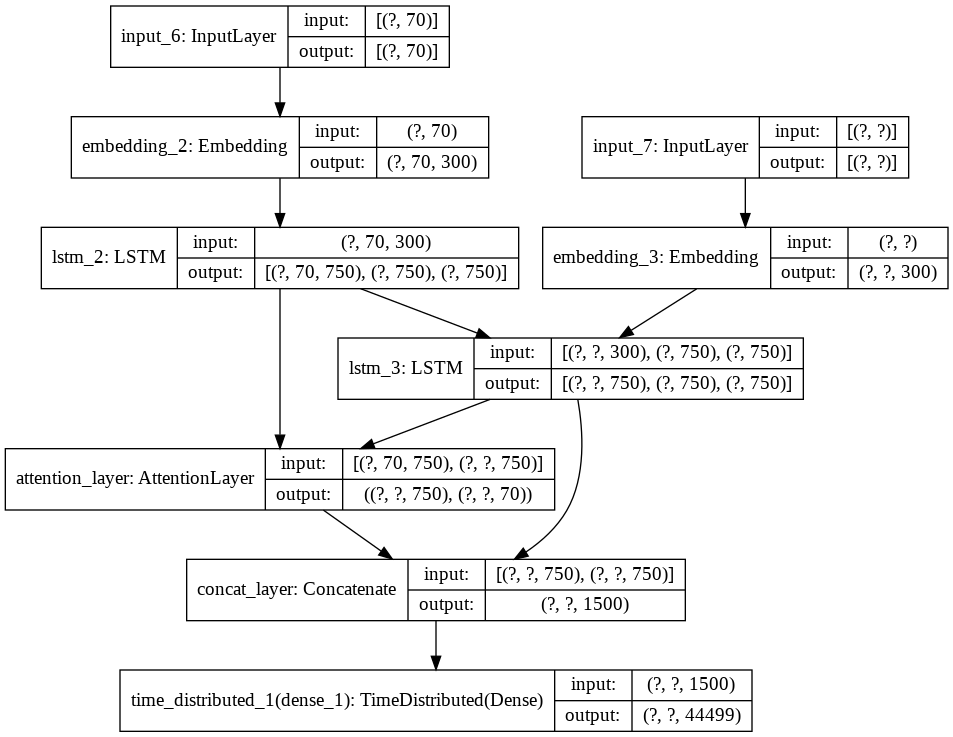

In [55]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [56]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
t1=padded_docs_train
t2=y_padded_docs_train
t1_cv=padded_docs_cv
t2_cv=y_padded_docs_cv
history=model.fit([t1,t2[:,:-1]],
                  t2.reshape(t2.shape[0],t2.shape[1], 1)[:,1:]
                  ,epochs=3,batch_size=32, validation_data=([t1_cv,t2_cv[:,:-1]],
                  t2_cv.reshape(t2_cv.shape[0],t2_cv.shape[1], 1)[:,1:]),
                  callbacks=[tensorboard_callback])

Train on 159273 samples, validate on 28107 samples
Epoch 1/3
159273/159273 [==============================] - 1010s 6ms/sample - loss: 2.9185 - val_loss: 2.2024
Epoch 2/3
159273/159273 [==============================] - 1005s 6ms/sample - loss: 1.7603 - val_loss: 1.7284
Epoch 3/3
159273/159273 [==============================] - 1000s 6ms/sample - loss: 1.2092 - val_loss: 1.6875


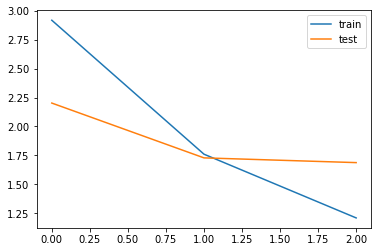

In [57]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Inference**

In [0]:
encoder_model = Model(inputs=encoder_input,outputs=[e_lstm_out, e_hidden_out, e_cell_out])

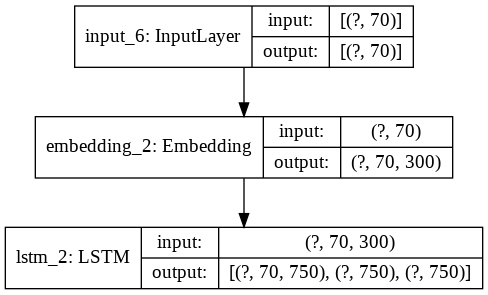

In [59]:
plot_model(encoder_model, to_file='model.png', show_shapes=True)

In [0]:
decoder_input_h = Input(shape=(750,))
decoder_input_c = Input(shape=(750,))
decoder_hidden_state = Input(shape=(70,750))

dec_emb2= decoder_embedding_layer(decoder_input) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_input_h, decoder_input_c])

attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_input] + [decoder_hidden_state,decoder_input_h, decoder_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


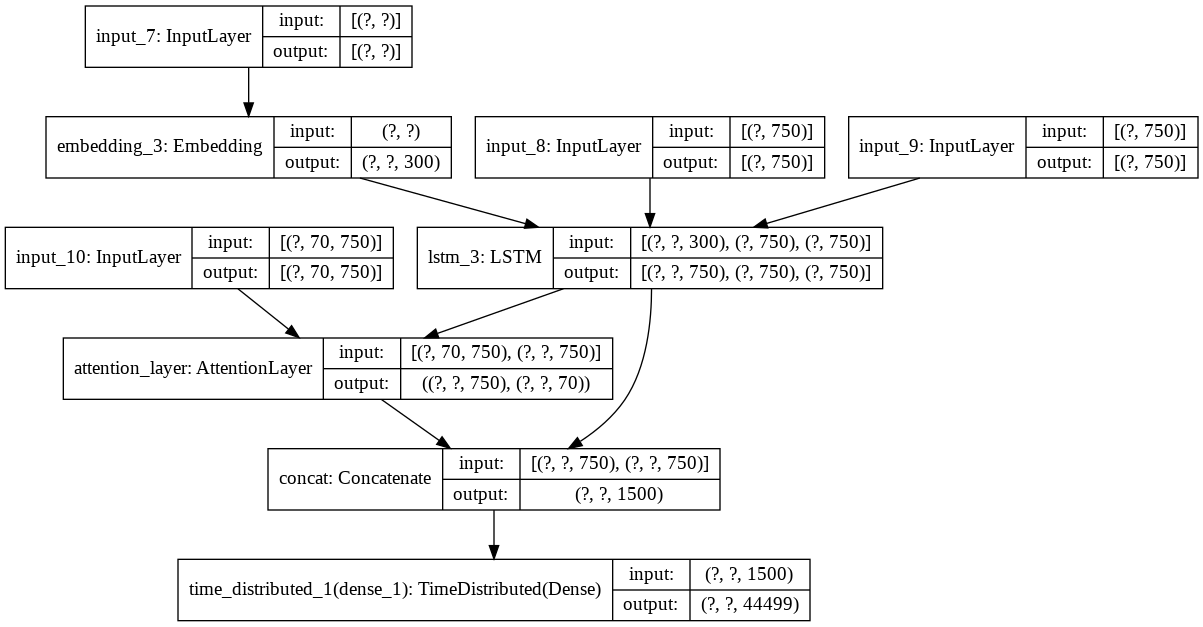

In [61]:
plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [0]:
# https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
# https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    seq[0, 0] = target_headlines_word_index['ssttaarrtt']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
      
        output, h, c = decoder_model.predict([seq] + [e_out, e_h, e_c])
        
        token_index = np.argmax(output[0, -1, :])
        if(token_index==0):
          token_index=2
        try:
          token = headlines_word_index[token_index]
                          
          if(token!='eenndd'):
            decoded_sentence += ' '+token

        # Exit condition: either hit max length or find stop word.
          if (token == 'eenndd'  or len(decoded_sentence.split()) >= (20-1)):
            stop_condition = True
        except:
          pass
        # Update the target sequence (of length 1).
        seq = np.zeros((1,1))
        seq[0, 0] = token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def headlines(input_seq):
    s=''
    for i in input_seq:
        if((i!=0 and i!=target_headlines_word_index['ssttaarrtt']) and i!=target_headlines_word_index['eenndd']):
            s=s+headlines_word_index[i]+' '
    return s

def news(input_seq):
    s=''
    
    for i in input_seq:
        if(i!=0):
            s=s+news_word_index[i]+' '
    return s


In [64]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_train[i]))
  print("Original headline:",headlines(y_padded_docs_train[i]))
  print("Predicted headline:",decode_sequence(padded_docs_train[i].reshape(1,70)))
  print("\n")

1
News: shah rukh khan while recalling time people apprehensive chak de india said everyone thought worst film made no heroine girls unknown look awful beard he added while talking film srk further said he does certain films because they appeal him organically 
Original headline: everyone said chak de india worst film made srk 
Predicted headline:  people thought worst film made no biopic srk


2
News: transportation security administration has announced more comprehensive involved physical screening of passengers at us airports new pat rule comes after audit homeland security revealed that airport officers failed detect guns weapons passengers us airports subjected pat searches they refuse pass through imaging scanners 
Original headline: pat downs at us airports get more invasive 
Predicted headline:  us airports get more invasive invasive


3
News: 20 year old indonesian man allegedly forged his diploma overstated his grades gain admission into police academy has arrested discrepanc

In [65]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_test[i]))
  print("Original headline:",headlines(y_padded_docs_test[i]))
  print("Predicted headline:",decode_sequence(padded_docs_test[i].reshape(1,70)))
  print("\n")

1
News: former american swimmer michael phelps decorated olympian of all time has said he extremely thankful that he not end his life while fighting depression 23 time olympic gold medalist added that he suffered depression after every olympic games his career phelps further said he not want live anymore after 2012 olympics 
Original headline: under depression after every olympics 23 time champion 
Predicted headline:  extremely grateful phelps phelps


2
News: proxy advisory firms come support of infosys co founder narayana murthy stance making panaya probe report public infosys earlier declined murthy request claimed that management has cleared of alleged wrongdoings advisory firms also questioned company stock performance asked founders specific plan put infosys back stability track 
Original headline: advisory firms back murthy over making panaya probe public 
Predicted headline:  infosys murthy supports murthy infosys chairman


3
News: konkona sen sharma has named best actress fi

## Model 3 BLEU score

In [66]:
h=[]
s=[]
for i in range(942):
  h1=[headlines(y_padded_docs_test[i]).split()]
  h.append(h1)
  s.append(decode_sequence(padded_docs_test[i].reshape(1,70)).split())

from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(h, s, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(h, s, weights=(0.5, 0.5, 0, 0)))


BLEU-1: 0.401676
BLEU-2: 0.263726


## **Model 4**

## **3-LSTM encoder + Bahdanau attention + Decoder**

In [0]:
from keras import backend as K 
logdir = "log4/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

emb_dim = 300

encoder_input = Input(shape=(70,))
x1=Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)(encoder_input)
encoder_lstm1 = LSTM(600,return_sequences=True,return_state=True) 

e_lstm_out, e_hidden_out, e_cell_out = encoder_lstm1(x1)

encoder_lstm2 = LSTM(600,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(e_lstm_out) 

encoder_lstm3=LSTM(600, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

decoder_input = Input(shape=(None,))

decoder_embedding_layer = Embedding(y_vocab_size, 300,weights=[decoder_matrix],trainable=False)
decoder_embedding = decoder_embedding_layer(decoder_input)

decoder_lstm = LSTM(600, return_sequences=True, return_state=True)
d_lstm_out,d_hidden_out,d_cell_out = decoder_lstm(decoder_embedding,initial_state=[state_h, state_c])

# https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
attention_layer = AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer([encoder_outputs, d_lstm_out])

# Concat attention input and decoder LSTM output
concat = Concatenate(axis=-1, name='concat_layer')([d_lstm_out, attention_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_dense_outputs = decoder_dense(concat)

# Define the model 
model = Model([encoder_input, decoder_input], decoder_dense_outputs)

model.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 70, 300)      31467900    input_15[0][0]                   
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 70, 600), (N 2162400     embedding_8[0][0]                
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

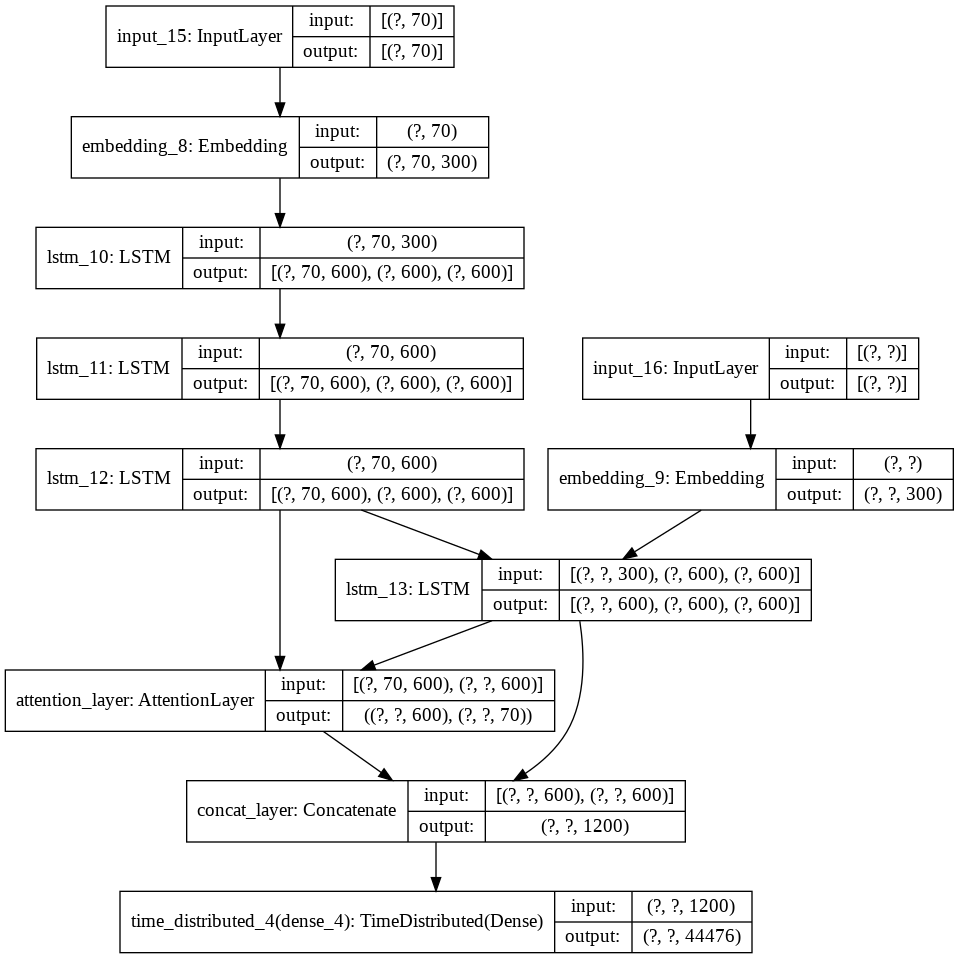

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
t1=padded_docs_train
t2=y_padded_docs_train
t1_cv=padded_docs_cv
t2_cv=y_padded_docs_cv
history=model.fit([t1,t2[:,:-1]],
                  t2.reshape(t2.shape[0],t2.shape[1], 1)[:,1:]
                  ,epochs=3,batch_size=32, validation_data=([t1_cv,t2_cv[:,:-1]],
                  t2_cv.reshape(t2_cv.shape[0],t2_cv.shape[1], 1)[:,1:]),
                  callbacks=[tensorboard_callback])

Train on 159273 samples, validate on 28107 samples
Epoch 1/3
159273/159273 [==============================] - 1917s 12ms/sample - loss: 2.9904 - val_loss: 2.3741
Epoch 2/3
159273/159273 [==============================] - 1911s 12ms/sample - loss: 2.0052 - val_loss: 1.9526
Epoch 3/3
159273/159273 [==============================] - 1907s 12ms/sample - loss: 1.4171 - val_loss: 1.8441


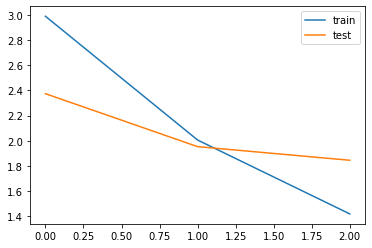

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
encoder_model = Model(inputs=encoder_input,outputs=[encoder_outputs, state_h, state_c])

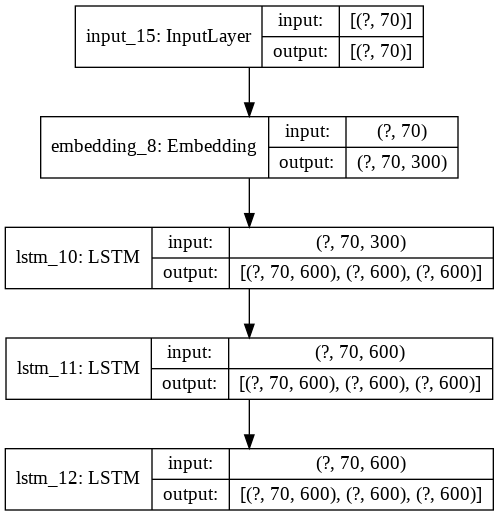

In [0]:
plot_model(encoder_model, to_file='model.png', show_shapes=True)

In [0]:
decoder_input_h = Input(shape=(600,))
decoder_input_c = Input(shape=(600,))
decoder_hidden_state = Input(shape=(70,600))

dec_emb2= decoder_embedding_layer(decoder_input) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_input_h, decoder_input_c])

attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_input] + [decoder_hidden_state,decoder_input_h, decoder_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


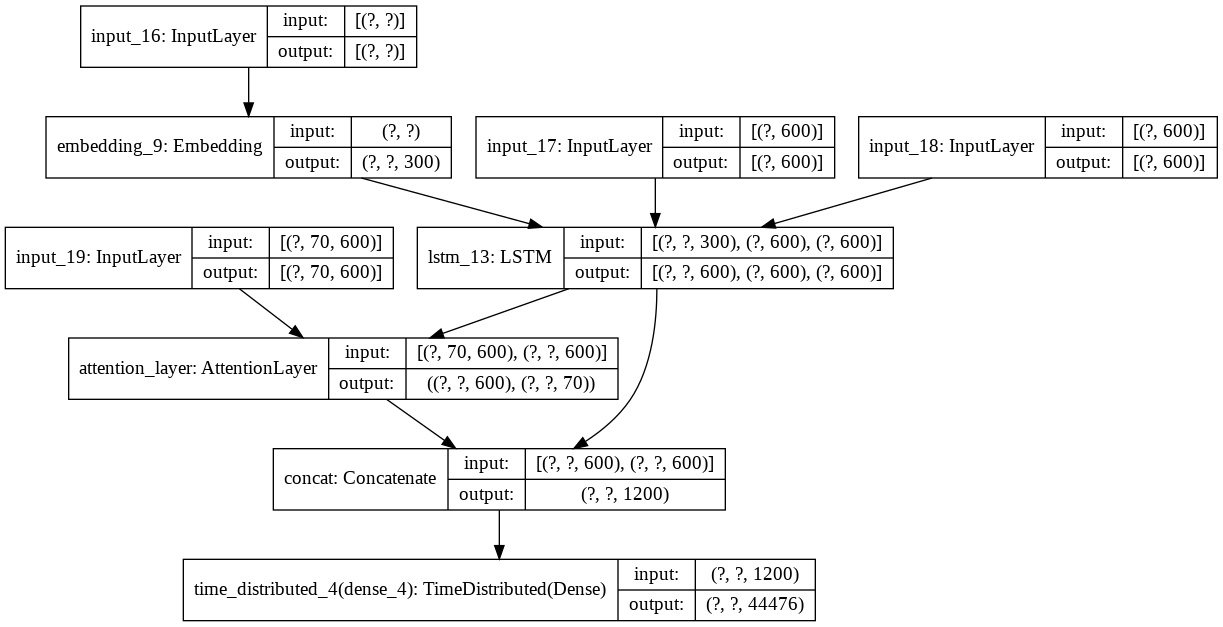

In [0]:
plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [0]:
# https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
# https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    seq[0, 0] = target_headlines_word_index['ssttaarrtt']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
      
        output, h, c = decoder_model.predict([seq] + [e_out, e_h, e_c])
        
        token_index = np.argmax(output[0, -1, :])
        if(token_index==0):
          token_index=2
        try:
          token = headlines_word_index[token_index]
                          
          if(token!='eenndd'):
            decoded_sentence += ' '+token

        # Exit condition: either hit max length or find stop word.
          if (token == 'eenndd'  or len(decoded_sentence.split()) >= (20-1)):
            stop_condition = True
        except:
          pass
        # Update the target sequence (of length 1).
        seq = np.zeros((1,1))
        seq[0, 0] = token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def headlines(input_seq):
    s=''
    for i in input_seq:
        if((i!=0 and i!=target_headlines_word_index['ssttaarrtt']) and i!=target_headlines_word_index['eenndd']):
            s=s+headlines_word_index[i]+' '
    return s

def news(input_seq):
    s=''
    
    for i in input_seq:
        if(i!=0):
            s=s+news_word_index[i]+' '
    return s


In [41]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_train[i]))
  print("Original headline:",headlines(y_padded_docs_train[i]))
  print("Predicted headline:",decode_sequence(padded_docs_train[i].reshape(1,70)))
  print("\n")

1
News: shah rukh khan while recalling time people apprehensive chak de india said everyone thought worst film made no heroine girls unknown look awful beard he added while talking film srk further said he does certain films because they appeal him organically 
Original headline: everyone said chak de india worst film made srk 
Predicted headline:  everyone thought worst film made no role srk


2
News: transportation security administration has announced more comprehensive involved physical screening of passengers at us airports new pat rule comes after audit homeland security revealed that airport officers failed detect guns weapons passengers us airports subjected pat searches they refuse pass through imaging scanners 
Original headline: pat downs at us airports get more invasive 
Predicted headline:  us airport security checks at airports


3
News: 20 year old indonesian man allegedly forged his diploma overstated his grades gain admission into police academy has arrested discrepanc

In [51]:
for i in range(5):
  print(int(i+1)
  print("News:",news(padded_docs_test[i]))
  print("Original headline:",headlines(y_padded_docs_test[i]))
  print("Predicted headline:",decode_sequence(padded_docs_test[i].reshape(1,70)))
  print("\n")

1
News: proxy advisory firms come support of infosys co founder narayana murthy stance making panaya probe report public infosys earlier declined murthy request claimed that management has cleared of alleged wrongdoings advisory firms also questioned company stock performance asked founders specific plan put infosys back stability track 
Original headline: advisory firms back murthy over making panaya probe public 
Predicted headline:  infosys board firmly support murthy report


2
News: mexico create new division of federal police preserve secure cultural heritage according officials division recruit officers knowledge of archaeology art prevent thefts looting of cultural artefacts officials said according official figures 90 of stolen cultural objects archaeological pieces religious art never recovered 
Original headline: mexico create new police division preserve culture 
Predicted headline:  mexico create new division police protect heritage heritage


3
News: karnataka congress mp

## Model 4 BLEU score

In [53]:
h=[]
s=[]
for i in range(942):
  h1=[headlines(y_padded_docs_test[i]).split()]
  h.append(h1)
  s.append(decode_sequence(padded_docs_test[i].reshape(1,70)).split())

from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(h, s, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(h, s, weights=(0.5, 0.5, 0, 0)))


BLEU-1: 0.323565
BLEU-2: 0.198645


## **Model 5**

## **Encoder(Bidirectional(lstm)) + Bahdanau Attention + Decoder(lstm)**

### **Best model**

In [25]:

from keras import backend as K 

emb_dim = 300

encoder_input = Input(shape=(70,))
x1=Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)(encoder_input)

encoder = Bidirectional(LSTM(units= 300, input_shape=(70,300),return_state=True,
                             return_sequences=True, dropout=0.5,recurrent_dropout=0.5))
encoder_out,f_h_out,f_cell_out,b_h_out,b_cell_out =encoder(x1)
state_h = Concatenate()([f_h_out, b_h_out])
state_c = Concatenate()([f_cell_out, b_cell_out])
#encoder_states = [state_h, state_c]


decoder_input = Input(shape=(None,))

decoder_embedding_layer = Embedding(y_vocab_size, 300,weights=[decoder_matrix],trainable=False)
decoder_embedding = decoder_embedding_layer(decoder_input)

decoder_lstm = LSTM(600, return_sequences=True, return_state=True,dropout=0.4)
d_lstm_out,d_hidden_out,d_cell_out = decoder_lstm(decoder_embedding,initial_state=[state_h,state_c])
#https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
attention_layer = AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer([encoder_out, d_lstm_out])

# Concat attention input and decoder LSTM output
concat = Concatenate(axis=-1, name='concat_layer')([d_lstm_out, attention_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(concat)

# Define the model 
model = Model([encoder_input, decoder_input], decoder_outputs)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (Non

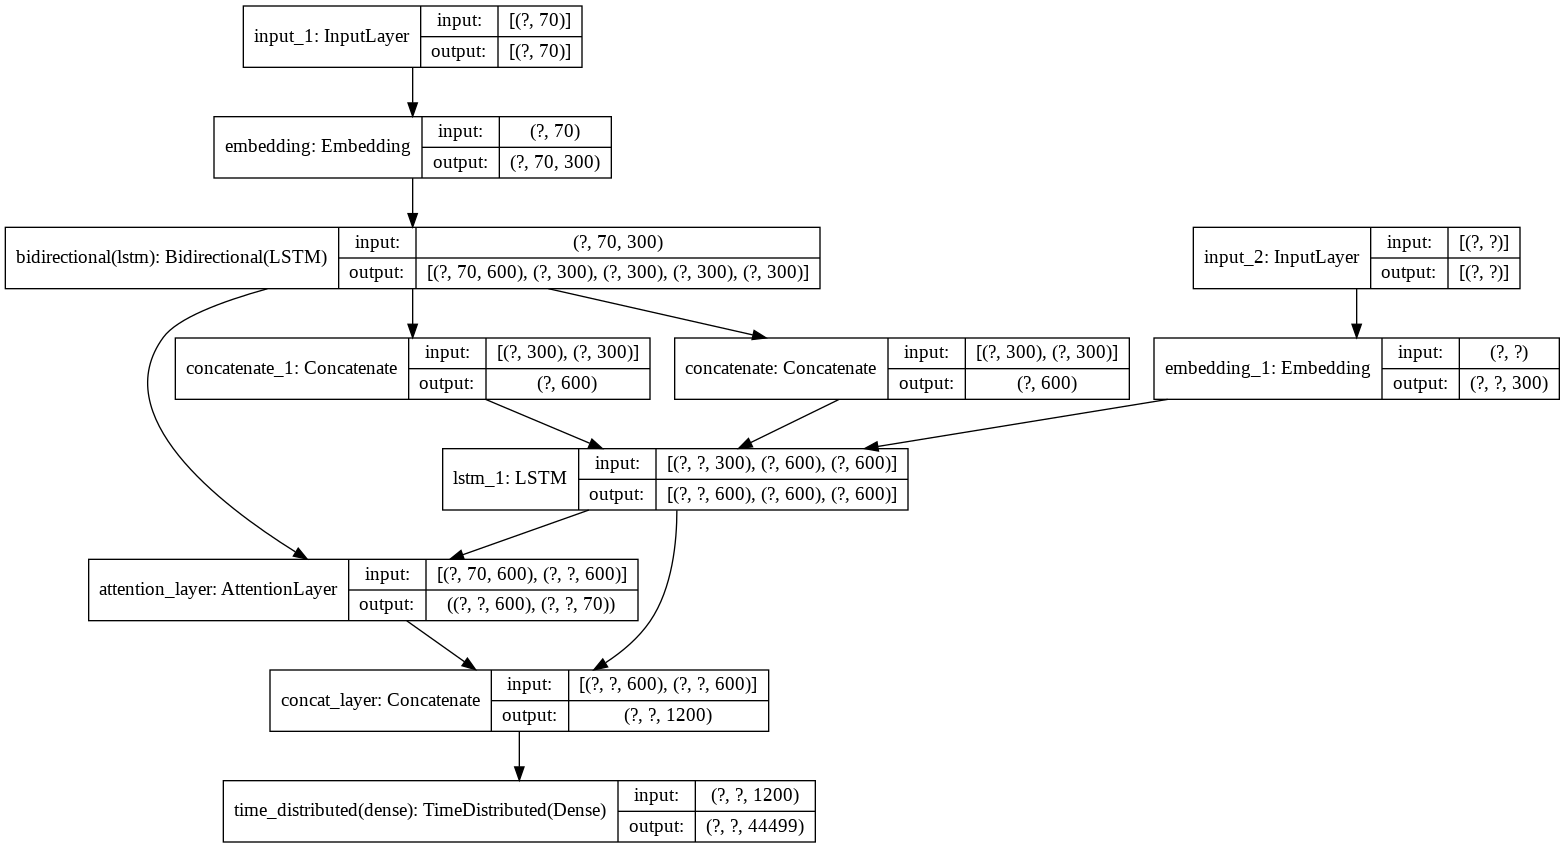

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [0]:
from tensorflow.keras import metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy' )

In [29]:
t1=padded_docs_train
t2=y_padded_docs_train
t1_cv=padded_docs_cv
t2_cv=y_padded_docs_cv
history=model.fit([t1,t2[:,:-1]],
                  t2.reshape(t2.shape[0],t2.shape[1], 1)[:,1:]
                  ,epochs=5,batch_size=32, validation_data=([t1_cv,t2_cv[:,:-1]],
                  t2_cv.reshape(t2_cv.shape[0],t2_cv.shape[1], 1)[:,1:]),
                  
                  )

Train on 159273 samples, validate on 28107 samples
Epoch 1/5
159273/159273 [==============================] - 1296s 8ms/sample - loss: 2.9617 - val_loss: 2.2864
Epoch 2/5
159273/159273 [==============================] - 1289s 8ms/sample - loss: 2.0959 - val_loss: 1.8806
Epoch 3/5
159273/159273 [==============================] - 1285s 8ms/sample - loss: 1.6900 - val_loss: 1.7747
Epoch 4/5
159273/159273 [==============================] - 1286s 8ms/sample - loss: 1.4701 - val_loss: 1.7733
Epoch 5/5
159273/159273 [==============================] - 1279s 8ms/sample - loss: 1.3252 - val_loss: 1.7558


In [0]:
news_word_index=t.index_word
headlines_word_index=y_tokenizer.index_word
target_headlines_word_index=y_tokenizer.word_index

In [0]:
encoder_model = Model(inputs=encoder_input,outputs=[encoder_out, state_h, state_c])

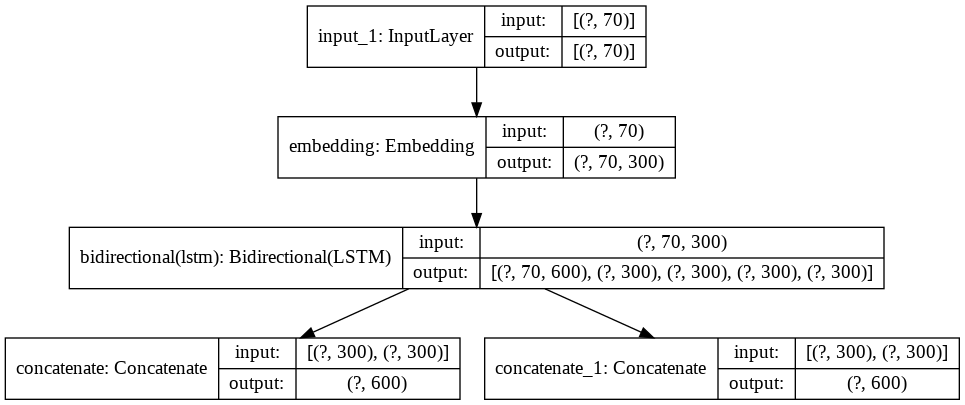

In [32]:
plot_model(encoder_model, to_file='model.png', show_shapes=True)

In [0]:
decoder_input_h = Input(shape=(600,))
decoder_input_c = Input(shape=(600,))
decoder_hidden_state = Input(shape=(70,600))

dec_emb2= decoder_embedding_layer(decoder_input) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_input_h, decoder_input_c])

attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_input] + [decoder_hidden_state,decoder_input_h, decoder_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


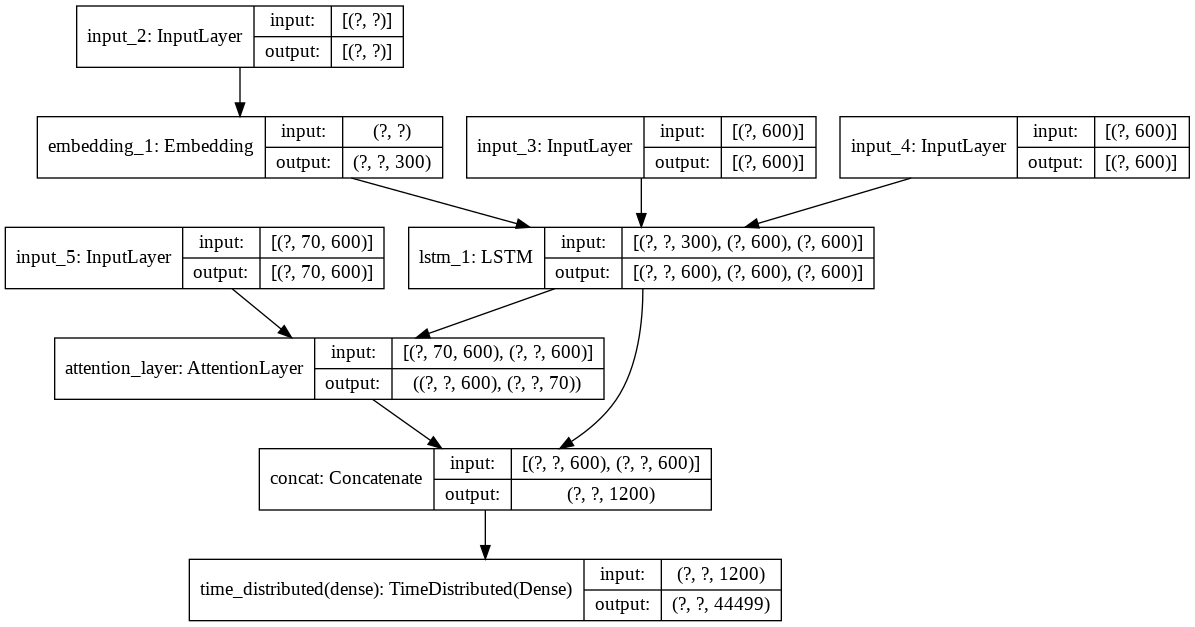

In [34]:
plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [0]:
#https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
#https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    seq[0, 0] = target_headlines_word_index['ssttaarrtt']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
      
        output, h, c = decoder_model.predict([seq] + [e_out, e_h, e_c])
        
        token_index = np.argmax(output[0, -1, :])
        try:
          token = headlines_word_index[token_index]
                          
          if(token!='eenndd'):
            decoded_sentence += ' '+token

        # Exit condition: either hit max length or find stop word.
          if (token == 'eenndd'  or len(decoded_sentence.split()) >= (20-1)):
            stop_condition = True
        except:
          pass
        # Update the target sequence (of length 1).
        seq = np.zeros((1,1))
        seq[0, 0] = token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def headlines(input_seq):
    s=''
    for i in input_seq:
        if((i!=0 and i!=target_headlines_word_index['ssttaarrtt']) and i!=target_headlines_word_index['eenndd']):
            s=s+headlines_word_index[i]+' '
    return s

def news(input_seq):
    s=''
    
    for i in input_seq:
        if(i!=0):
            s=s+news_word_index[i]+' '
    return s


In [37]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_train[i]))
  print("Original headline:",headlines(y_padded_docs_train[i]))
  print("Predicted headline:",decode_sequence(padded_docs_train[i].reshape(1,70)))
  print("\n")

1
News: shah rukh khan while recalling time people apprehensive chak de india said everyone thought worst film made no heroine girls unknown look awful beard he added while talking film srk further said he does certain films because they appeal him organically 
Original headline: everyone said chak de india worst film made srk 
Predicted headline:  everyone thought worst film made no role srk


2
News: transportation security administration has announced more comprehensive involved physical screening of passengers at us airports new pat rule comes after audit homeland security revealed that airport officers failed detect guns weapons passengers us airports subjected pat searches they refuse pass through imaging scanners 
Original headline: pat downs at us airports get more invasive 
Predicted headline:  us airport security checks at airports


3
News: 20 year old indonesian man allegedly forged his diploma overstated his grades gain admission into police academy has arrested discrepanc

In [44]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_test[i]))
  print("Original headline:",headlines(y_padded_docs_test[i]))
  print("Predicted headline:",decode_sequence(padded_docs_test[i].reshape(1,70)))
  print("\n")

1
News: former american swimmer michael phelps decorated olympian of all time has said he extremely thankful that he not end his life while fighting depression 23 time olympic gold medalist added that he suffered depression after every olympic games his career phelps further said he not want live anymore after 2012 olympics 
Original headline: under depression after every olympics 23 time champion 
Predicted headline:  very grateful life meaningless phelps phelps


2
News: proxy advisory firms come support of infosys co founder narayana murthy stance making panaya probe report public infosys earlier declined murthy request claimed that management has cleared of alleged wrongdoings advisory firms also questioned company stock performance asked founders specific plan put infosys back stability track 
Original headline: advisory firms back murthy over making panaya probe public 
Predicted headline:  infosys board firmly support murthy report


3
News: konkona sen sharma has named best act

## Model 5 BLEU score

In [43]:
h=[]
s=[]
for i in range(942):
  h1=[headlines(y_padded_docs_test[i]).split()]
  h.append(h1)
  s.append(decode_sequence(padded_docs_test[i].reshape(1,70)).split())

from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(h, s, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(h, s, weights=(0.5, 0.5, 0, 0)))


BLEU-1: 0.416519
BLEU-2: 0.277199


## **Model 6**

## **Encoder(Bidir(Lstm) + lstm + Bidir(Lstm)) + Bahdanau attention + Decoder(Lstm)**

In [67]:
from keras import backend as K 

emb_dim = 300

encoder_input = Input(shape=(70,))
x1=Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)(encoder_input)

                
encoder = Bidirectional(LSTM(units= 300,return_state=True,
                             return_sequences=True, dropout=0.5,recurrent_dropout=0.5))
encoder_out,f_h_out,f_cell_out,b_h_out,b_cell_out =encoder(x1)
#B = multiply([f_out, b_out])
#state_h = Concatenate()([f_h_out, b_h_out])
#state_c = Concatenate()([f_cell_out, b_cell_out])
#encoder_states = [state_h, state_c]
l1  = LSTM(300, return_state=True,return_sequences=True,dropout=0.4,recurrent_dropout=0.25)
a,b,c = l1(encoder_out)

encoder1 = Bidirectional(LSTM(units= 300,return_state=True,
                             return_sequences=True, dropout=0.5,recurrent_dropout=0.5))

encoder_out1,f_h_out1,f_cell_out1,b_h_out1,b_cell_out1 =encoder1(a)
state_h1 = Concatenate()([f_h_out1, b_h_out1])
state_c1 = Concatenate()([f_cell_out1, b_cell_out1])

decoder_input = Input(shape=(None,))

decoder_embedding_layer = Embedding(y_vocab_size, 300,weights=[decoder_matrix],trainable=False)
decoder_embedding = decoder_embedding_layer(decoder_input)

decoder_lstm = LSTM(600, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.5)
d_lstm_out,d_hidden_out,d_cell_out = decoder_lstm(decoder_embedding,initial_state=[state_h1,state_c1])
#https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
attention_layer = AttentionLayer(name='attention_layer')
attention_out, attention_states = attention_layer([encoder_out1, d_lstm_out])

# Concat attention input and decoder LSTM output
concat = Concatenate(axis=-1, name='concat_layer')([d_lstm_out, attention_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(concat)

# Define the model 
model = Model([encoder_input, decoder_input], decoder_outputs)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 70, 300)      31483500    input_11[0][0]                   
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 70, 600), (N 1442400     embedding_4[0][0]                
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 70, 300), (N 1081200     bidirectional_1[0][0]            
____________________________________________________________________________________________

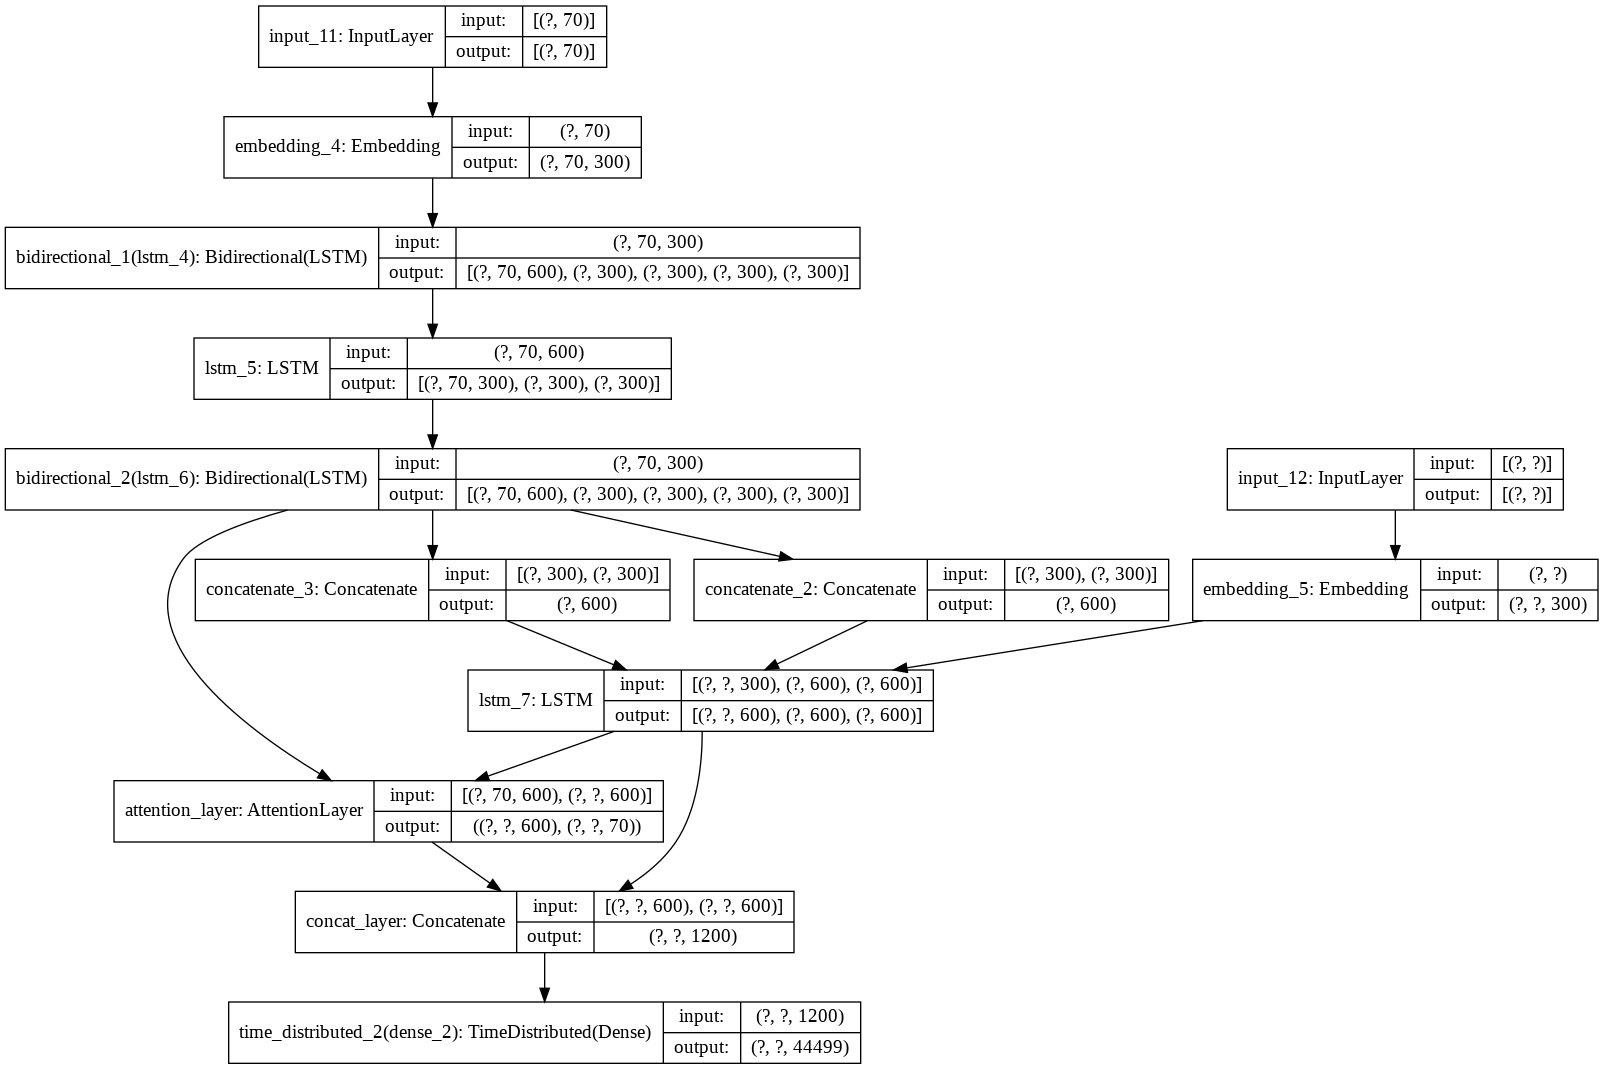

In [68]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [70]:
history=model.fit([t1,t2[:,:-1]],
                  t2.reshape(t2.shape[0],t2.shape[1], 1)[:,1:]
                  ,epochs=5,batch_size=32, validation_data=([t1_cv,t2_cv[:,:-1]],
                  t2_cv.reshape(t2_cv.shape[0],t2_cv.shape[1], 1)[:,1:]))


Train on 159273 samples, validate on 28107 samples
Epoch 1/5
159273/159273 [==============================] - 3177s 20ms/sample - loss: 3.2218 - val_loss: 2.7048
Epoch 2/5
159273/159273 [==============================] - 3204s 20ms/sample - loss: 2.5643 - val_loss: 2.3538
Epoch 3/5
159273/159273 [==============================] - 3178s 20ms/sample - loss: 2.1724 - val_loss: 2.1339
Epoch 4/5
159273/159273 [==============================] - 3160s 20ms/sample - loss: 1.8883 - val_loss: 2.0087
Epoch 5/5
159273/159273 [==============================] - 3161s 20ms/sample - loss: 1.6848 - val_loss: 1.9442


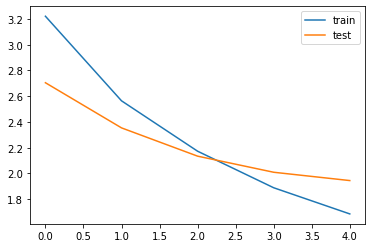

In [72]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
news_word_index=t.index_word
headlines_word_index=y_tokenizer.index_word
target_headlines_word_index=y_tokenizer.word_index

In [0]:
encoder_model = Model(inputs=encoder_input,outputs=[encoder_out1, state_h1, state_c1])

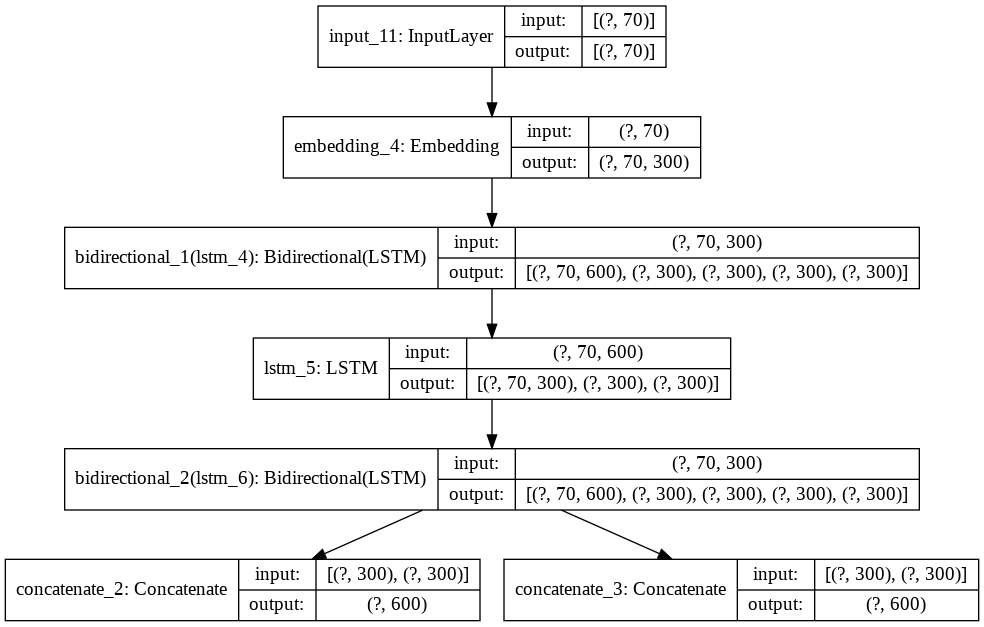

In [75]:
plot_model(encoder_model, to_file='model.png', show_shapes=True)

In [0]:
decoder_input_h = Input(shape=(600,))
decoder_input_c = Input(shape=(600,))
decoder_hidden_state = Input(shape=(70,600))

dec_emb2= decoder_embedding_layer(decoder_input) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_input_h, decoder_input_c])

attn_out_inf, attn_states_inf = attention_layer([decoder_hidden_state, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_input] + [decoder_hidden_state,decoder_input_h, decoder_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


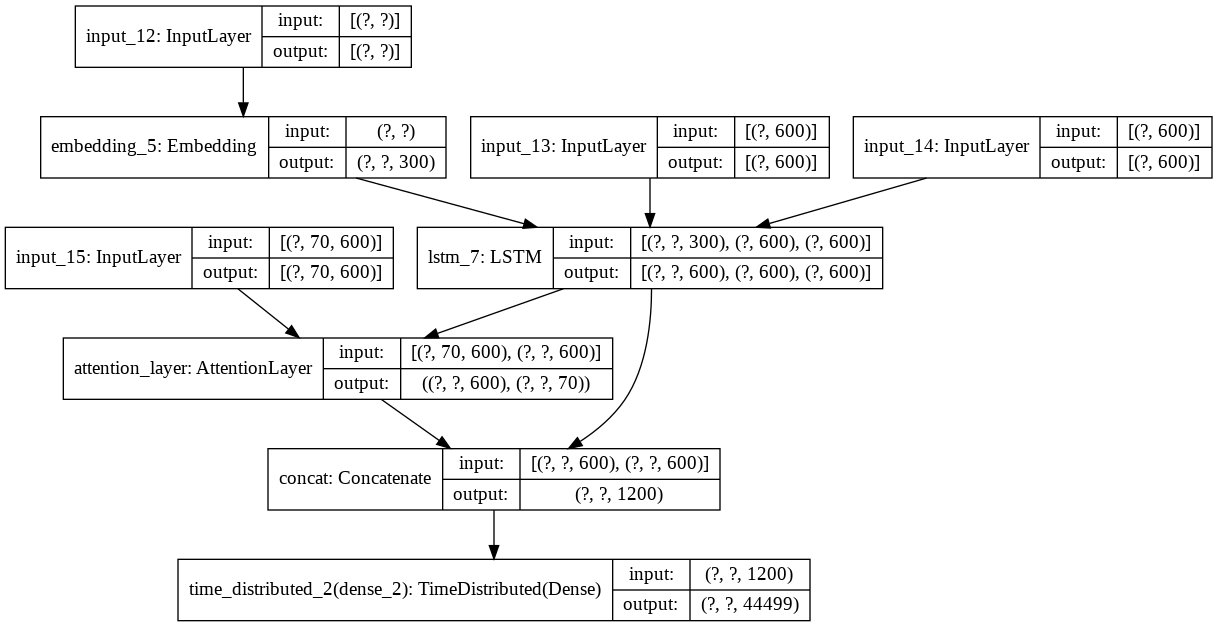

In [77]:
plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [0]:
#https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
#https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    seq[0, 0] = target_headlines_word_index['ssttaarrtt']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
      
        output, h, c = decoder_model.predict([seq] + [e_out, e_h, e_c])
        
        token_index = np.argmax(output[0, -1, :])
        if(token_index==0):
          token_index=2
        try:
          token = headlines_word_index[token_index]
                          
          if(token!='eenndd'):
            decoded_sentence += ' '+token

        # Exit condition: either hit max length or find stop word.
          if (token == 'eenndd'  or len(decoded_sentence.split()) >= (20-1)):
            stop_condition = True
        except:
          pass
        # Update the target sequence (of length 1).
        seq = np.zeros((1,1))
        seq[0, 0] = token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def headlines(input_seq):
    s=''
    for i in input_seq:
        if((i!=0 and i!=target_headlines_word_index['ssttaarrtt']) and i!=target_headlines_word_index['eenndd']):
            s=s+headlines_word_index[i]+' '
    return s

def news(input_seq):
    s=''
    
    for i in input_seq:
        if(i!=0):
            s=s+news_word_index[i]+' '
    return s


In [80]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_train[i]))
  print("Original headline:",headlines(y_padded_docs_train[i]))
  print("Predicted headline:",decode_sequence(padded_docs_train[i].reshape(1,70)))
  print("\n")

1
News: shah rukh khan while recalling time people apprehensive chak de india said everyone thought worst film made no heroine girls unknown look awful beard he added while talking film srk further said he does certain films because they appeal him organically 
Original headline: everyone said chak de india worst film made srk 
Predicted headline:  everyone worst film made no filmfare srk


2
News: transportation security administration has announced more comprehensive involved physical screening of passengers at us airports new pat rule comes after audit homeland security revealed that airport officers failed detect guns weapons passengers us airports subjected pat searches they refuse pass through imaging scanners 
Original headline: pat downs at us airports get more invasive 
Predicted headline:  us airports get new rules check check security


3
News: 20 year old indonesian man allegedly forged his diploma overstated his grades gain admission into police academy has arrested discre

In [81]:
for i in range(5):
  print(i+1)
  print("News:",news(padded_docs_test[i]))
  print("Original headline:",headlines(y_padded_docs_test[i]))
  print("Predicted headline:",decode_sequence(padded_docs_test[i].reshape(1,70)))
  print("\n")

1
News: former american swimmer michael phelps decorated olympian of all time has said he extremely thankful that he not end his life while fighting depression 23 time olympic gold medalist added that he suffered depression after every olympic games his career phelps further said he not want live anymore after 2012 olympics 
Original headline: under depression after every olympics 23 time champion 
Predicted headline:  very happy that not end life phelps phelps


2
News: proxy advisory firms come support of infosys co founder narayana murthy stance making panaya probe report public infosys earlier declined murthy request claimed that management has cleared of alleged wrongdoings advisory firms also questioned company stock performance asked founders specific plan put infosys back stability track 
Original headline: advisory firms back murthy over making panaya probe public 
Predicted headline:  infosys nilekani opposes infosys founders panaya probe


3
News: konkona sen sharma has name

## Model 6 BLEU score

In [84]:
h=[]
s=[]
for i in range(942):
  h1=[headlines(y_padded_docs_test[i]).split()]
  h.append(h1)
  s.append(decode_sequence(padded_docs_test[i].reshape(1,70)).split())

from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(h, s, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(h, s, weights=(0.5, 0.5, 0, 0)))


BLEU-1: 0.323708
BLEU-2: 0.197235


## Conclusion

In [10]:
from prettytable import PrettyTable
x = PrettyTable()
 

x.field_names = ['Model no',"Architecture", "BLEU-1","BLEU-2"]
x.add_row(['1','Encoder(1-Lstm) + attention + Decoder(1-Lstm)','0.132946','0.053922'])
x.add_row(['2','Encoder(1-Lstm) + attention + Decoder(1-Lstm) stop words \n not removed from headlines','0.365156','0.232804'])
x.add_row(['3','Encoder(1-Lstm) + attention + Decoder(1-Lstm)','0.401676','0.263726'])
x.add_row(['4','Encoder(3-Lstm) + attention + Decoder(1-Lstm)','0.323565','0.198645'])
x.add_row(['5','Encoder(Bidir(Lstm) + Attention + Decoder(1-Lstm)','0.416519','0.277199'])
x.add_row(['6','Encoder(Bidir(Lstm) + lstm + Bidir(Lstm)) + attention + Decoder(1-Lstm)','0.323708','0.197235'])

print(x)

+----------+-------------------------------------------------------------------------+----------+----------+
| Model no |                               Architecture                              |  BLEU-1  |  BLEU-2  |
+----------+-------------------------------------------------------------------------+----------+----------+
|    1     |              Encoder(1-Lstm) + attention + Decoder(1-Lstm)              | 0.132946 | 0.053922 |
|    2     |        Encoder(1-Lstm) + attention + Decoder(1-Lstm) stop words         | 0.365156 | 0.232804 |
|          |                        not removed from headlines                       |          |          |
|    3     |              Encoder(1-Lstm) + attention + Decoder(1-Lstm)              | 0.401676 | 0.263726 |
|    4     |              Encoder(3-Lstm) + attention + Decoder(1-Lstm)              | 0.323565 | 0.198645 |
|    5     |            Encoder(Bidir(Lstm) + Attention + Decoder(1-Lstm)            | 0.416519 | 0.277199 |
|    6     | Encode

**Observation: Model 5 is the best with BLEU-1 = 0.416519 and BLEU-2 = 0.277199**



**Future scope**
- We have trained the network on 1.5 lakhs datapoints, increasing the no of datapoints can help improve accuracy.
- Better hyperparameter tuning and architecture.
- using Beam search decoding
- pointer generator network
- pre-trained BERT model

**Refrences**
- https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
- https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
- https://www.appliedaicourse.com/
- https://arxiv.org/abs/1512.01712
- https://arxiv.org/abs/1409.0473